# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [21]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [22]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [23]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 8 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [24]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 100
image_width = 100
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int) #create a list of image numbers you want to use fo

from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

In [25]:
from skimage.io import imread
from skimage.transform import resize

def resize_crop_image(image):
    if image.shape[0] > 120 and image.shape[1] > 120:
        image = resize(image, (120, 120))
        
    height = image.shape[0]
    width = image.shape[1]
    height_center = height//2
    width_center = width//2
    image = image[(height_center-60):(height_center+70), (width_center-50):(width_center+70)]
    image = resize(image,(image_height, image_width))
    return image

Let's test the function resize_crop_image by writing a test function

In [26]:
from matplotlib import pyplot as plt

def show_resize_crop_image(paths):

    for index, path in enumerate(paths):
        plt.figure(figsize=(20,20))
            
        plt.subplot(5, 2, index*2+1)
        image = resize_crop_image(imread(path))
        plt.imshow(image)
        plt.title('Modified')
        
        plt.subplot(5, 2, index*2+2)
        plt.imshow(imread(path))
        plt.title('Original')
                
    plt.show()

Calling the test function

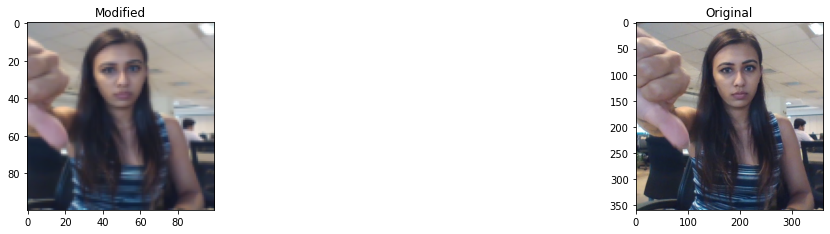

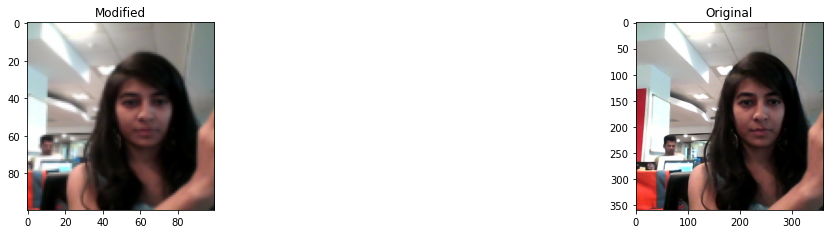

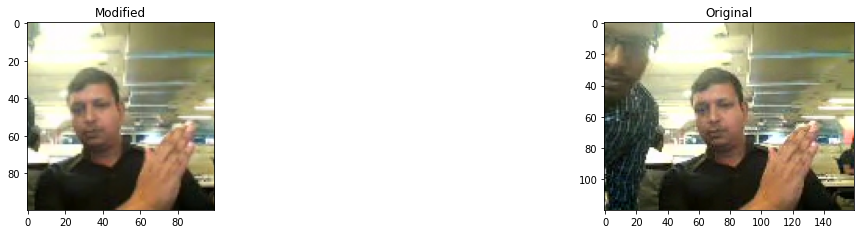

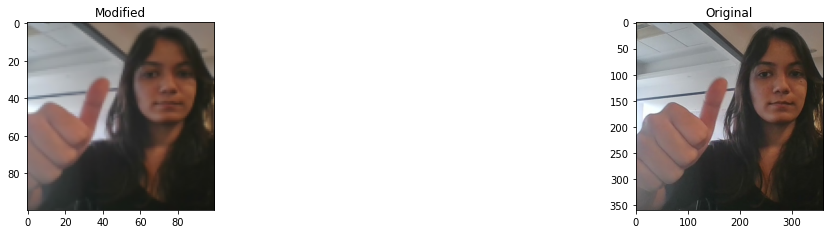

In [27]:
paths = ["/home/datasets/Project_data/train/WIN_20180907_15_53_00_Pro_Thumbs Down_new/WIN_20180907_15_53_00_Pro_00001.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_56_38_Pro_Right Swipe_new/WIN_20180907_15_56_38_Pro_00013.png",
        "/home/datasets/Project_data/train/WIN_20180925_17_22_32_Pro_Right_Swipe_new/WIN_20180925_17_22_32_Pro_00009.png",
        "/home/datasets/Project_data/train/WIN_20180907_15_53_12_Pro_Thumbs Up_new/WIN_20180907_15_53_12_Pro_00011.png"]

show_resize_crop_image(paths)


In [28]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = resize_crop_image(image)
                                         
                    batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        # write the code for the remaining data points which are left after full batches
        if (len(folder_list) != batch_size * num_batches):
            batch_size = len(folder_list) - (batch_size*num_batches)
            
            for batch in range(batch_size): # we iterate over the number of batches
                batch_data = np.zeros((batch_size, len(img_idx), image_height, image_width, 3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
                batch_labels = np.zeros((batch_size, gestures)) # batch_labels is the one hot representation of the output
                for folder in range(batch_size): # iterate over the batch_size
                    imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                    for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                        image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                        #crop the images and resize them. Note that the images are of 2 different shape 
                        #and the conv3D will throw error if the inputs in a batch have different shapes
                        image = resize_crop_image(image)
                                         
                        batch_data[folder,idx,:,:,0] = image[:,:,0] #normalise and feed in the image
                        batch_data[folder,idx,:,:,1] = image[:,:,1] #normalise and feed in the image
                        batch_data[folder,idx,:,:,2] = image[:,:,2] #normalise and feed in the image
                    
                    batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
         

*Code defines a generator function for creating batches of data and labels during training. The generator will be used to feed data to the model during the training process, allowing it to process data in batches efficiently.*


*The generator efficiently preprocesses and yields batches of video frames and one-hot encoded labels for training the 3D Convolutional Neural Network (CNN) model for gesture recognition. The specific implementation of resize_crop_image function and other details related to model training and evaluation are not shown in this code snippet but would be crucial for the overall success of the model.*

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [29]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 25


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Experiment 1

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

*Experiment 1 defines a 3D Convolutional Neural Network (CNN) model using the Keras Sequential API. The model is designed to classify gestures based on video frames. The primary focus is to achieve good accuracy while minimizing the number of parameters to fit within the memory constraints of the webcam.*

*Overall, this architecture starts with three Conv3D layers with small filter sizes to capture spatial features, followed by MaxPooling3D layers for spatial downsampling. The Flatten layer converts the spatial information into a 1D vector, and the two Dense layers add non-linearity and complexity to the model. Dropout layers help in reducing overfitting.*

*The model is designed to achieve good accuracy while being memory-efficient to fit within the constraints of the webcam. The actual performance of the model depends on various factors, such as the complexity of the dataset, the choice of hyperparameters, data augmentation, and optimization strategy.*

*It's important to note that the success of the model depends on how well it generalizes to unseen data, especially when applied to real-world scenarios. Fine-tuning and experimentation with hyperparameters, model architecture, and regularization techniques are common practices to improve model performance. Additionally, adding data augmentation and using early stopping can further enhance the model's accuracy and generalization capabilities.*

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [31]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 15, 100, 100, 8)   656       
                                                                 
 batch_normalization_6 (Batc  (None, 15, 100, 100, 8)  32        
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 15, 100, 100, 8)   0         
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 7, 50, 50, 8)     0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 7, 50, 50, 16)     3472      
                                                                 
 batch_normalization_7 (Batc  (None, 7, 50, 50, 16)   

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


*Model has a relatively small number of parameters, making it suitable for fitting within the memory constraints of the webcam. The model's architecture includes Conv3D layers to capture spatial information from video frames, followed by pooling, dense, and dropout layers for classification. The chosen optimizer is Stochastic Gradient Descent (SGD) with specific hyperparameters. The model can be trained using the specified loss function ('categorical_crossentropy') and metrics ('categorical_accuracy') to perform gesture recognition with reasonable accuracy. However, the final performance of the model would depend on the dataset's complexity, the choice of hyperparameters, regularization techniques, and the quality of data augmentation used during training. It's recommended to experiment with different configurations and fine-tuning to achieve the best results.*

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [32]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [33]:
model_name = 'model_init_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [34]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [35]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25


2023-08-03 14:47:52.167814: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


83/83 [==============================] - ETA: 0s - loss: 1.7359 - categorical_accuracy: 0.2534Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.56848, saving model to model_init_2023-08-0314_47_32.996425/model-00001-1.73586-0.25339-1.56848-0.22000.h5
83/83 [==============================] - 86s 1s/step - loss: 1.7359 - categorical_accuracy: 0.2534 - val_loss: 1.5685 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5867 - categorical_accuracy: 0.2978
Epoch 00002: val_loss improved from 1.56848 to 1.39173, saving model to model_init_2023-08-0314_47_32.996425/model-00002-1.58668-0.29776-1.39173-0.38462.h5
83/83 [==============================] - 70s 846ms/step - loss: 1.5867 - categorical_accuracy: 0.2978 - val_loss: 1.3917 - val_categorical_accuracy: 0.3846 - lr: 0.0010
Epoch 3/25
83/83 [==============================] - ETA: 0s - loss: 1.5201 - categorical_acc

#### *The model training process has been completed, and the training and validation accuracies and losses are displayed for each epoch. The output shows the training and validation performance over 25 epochs. Below are some observations:*

*The training process starts with a low categorical accuracy of around 0.25 and gradually improves over the epochs.*

*The validation accuracy also increases, but it might fluctuate in some epochs, which is typical for training neural networks.*

*The training loss (categorical_crossentropy) starts at a relatively high value and decreases with each epoch, which indicates that the model is learning from the data.*

*The validation loss follows a similar trend, reducing over the epochs, but it may also have some fluctuations.*

*The learning rate is reduced using the ReduceLROnPlateau callback when the validation loss plateaus, allowing the model to fine-tune the learning rate and potentially find a better minima.*

*The model seems to have a validation accuracy of around 0.63 at the end of 25 epochs, indicating that it has learned some patterns from the data.*

*As the validation accuracy is not consistently high, there may be potential for further model optimization or data augmentation to improve performance.*

*The number of trainable parameters in the model is 317,557, which is relatively small considering the 3D Convolutional Neural Network architecture.*

**Training Accuracy:** 0.51%

**Validation Accuracy:** 0.63%

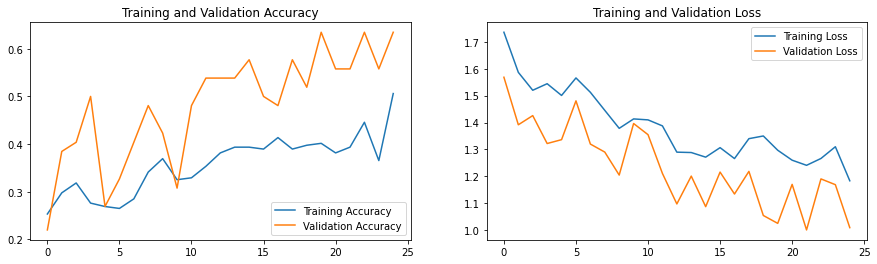

In [36]:
from IPython.display import Markdown, display

def plot_history(history):
    display(Markdown("**Training Accuracy:** " + str(round(history.history['categorical_accuracy'][num_epochs-1], 2)) + "%"))
    display(Markdown("**Validation Accuracy:** " + str(round(history.history['val_categorical_accuracy'][num_epochs-1], 2)) + "%"))
    
    #print("Training Accuracy:" + history.history['categorical_accuracy'][num_epochs-1])
    #print("Validation Accuracy:" + history.history['val_categorical_accuracy'][num_epochs-1])

    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(15, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_history(history)

From the graph we can see that the model is performing better on the validation data than on the training data. This indicates that the model is too simple and has lesser that required training parameters

## Experiment 2
#### Reducing the size of the image from 100 to 50

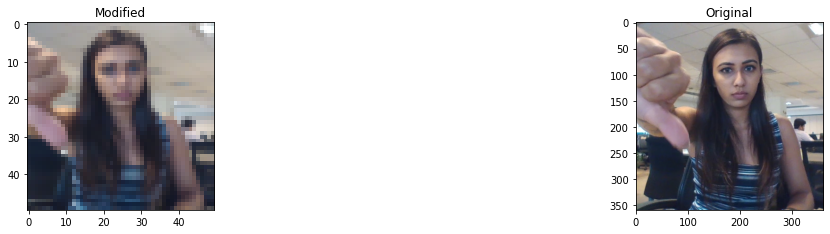

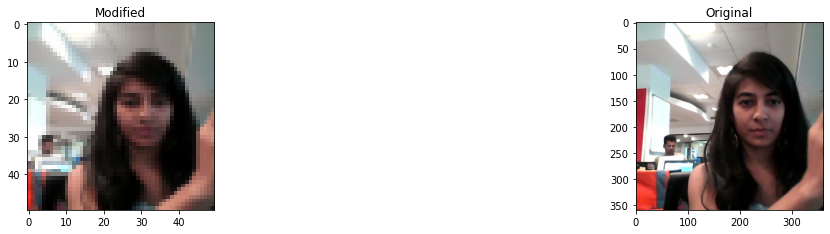

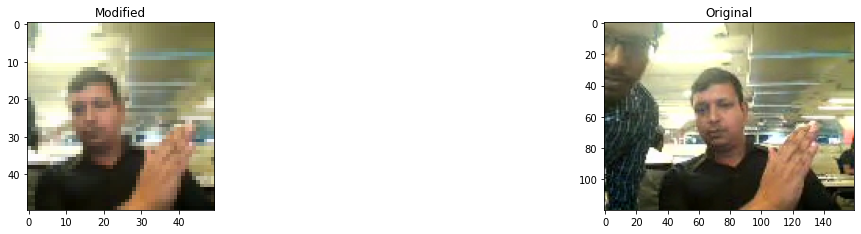

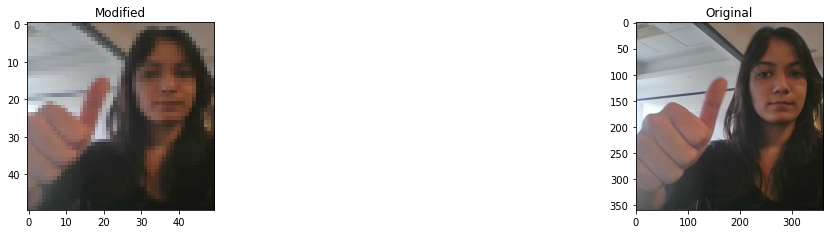

In [37]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [38]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

*Experiment 2 involves reducing the size of the input images from 100x100 to 50x50. Additionally, the number of frames used is 15 out of a total of 30 frames per video.*

*The model now uses 15 frames of 50x50 images as input. The rest of the architecture remains the same. After compiling the model, it's ready for training with the new image size.*






#### Compiling the model and printing the summary of the model

In [40]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_9 (Batc  (None, 15, 50, 50, 8)    32        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 7, 25, 25, 8)     0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_10 (Bat  (None, 7, 25, 25, 16)   

*The total number of trainable parameters in this model is 96,373. The model architecture remains the same as in Experiment 1, but with the input image size reduced to 50x50. Now, the model is ready for training with the resized images.*

##### Creating the generators

In [41]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [42]:
model_name = 'model_exp2_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

#### Fit the model and save the model parameters

In [44]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9370 - categorical_accuracy: 0.1976Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.64344, saving model to model_exp2_2023-08-0314_47_32.996425/model-00001-1.93701-0.19759-1.64344-0.24000.h5
83/83 [==============================] - 77s 937ms/step - loss: 1.9370 - categorical_accuracy: 0.1976 - val_loss: 1.6434 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.6150 - categorical_accuracy: 0.2857
Epoch 00002: val_loss improved from 1.64344 to 1.55057, saving model to model_exp2_2023-08-0314_47_32.996425/model-00002-1.61503-0.28571-1.55057-0.32692.h5
83/83 [==============================] - 63s 768ms/step - loss: 1.6150 - categorical_accuracy: 0.2857 - val_loss: 1.5506 - val_categorical_accuracy: 0.3269 - lr: 0.0010
Epoch 3/25
8

*The training process seems to have completed with 25 epochs, and the output shows the training and validation metrics for each epoch. Here's a summary of the training and validation metrics for the last epoch (Epoch 25):*

Training Loss: 1.2976

Training Categorical Accuracy: 0.4699 (46.99%)

Validation Loss: 1.1508

Validation Categorical Accuracy: 0.5192 (51.92%)

*It's evident that the model is overfitting since the training accuracy (46.99%) is significantly lower than the validation accuracy (51.92%). This is often the case when the model starts to memorize the training data instead of generalizing well to unseen data.*

##### Evaluate the performance of this model

**Training Accuracy:** 0.47%

**Validation Accuracy:** 0.52%

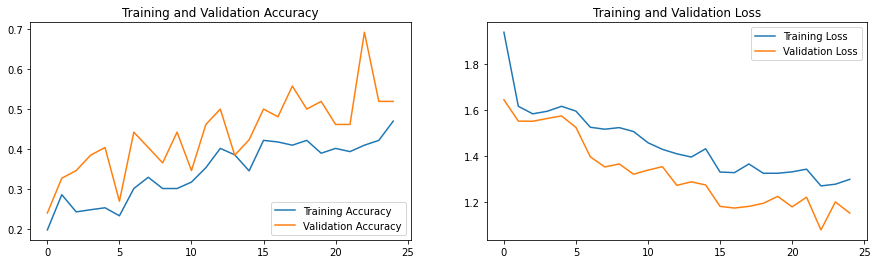

In [45]:
plot_history(history)

#### Conclusion: Scaling to smaller images work better



## Experiment 3
#### Reducing the size of the image from 50 to 25

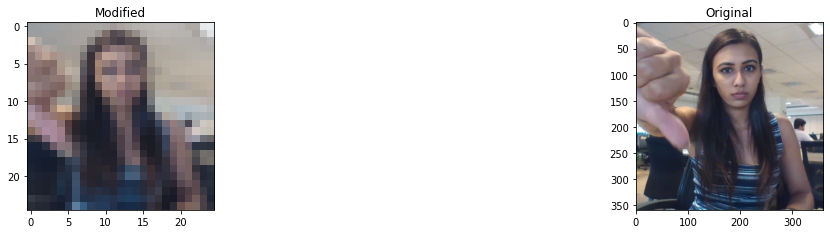

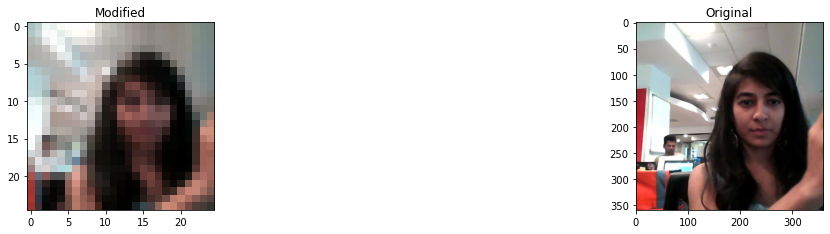

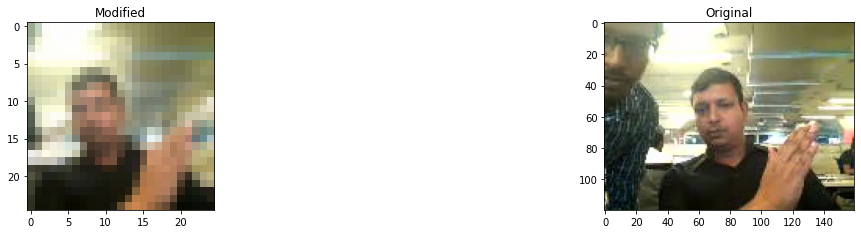

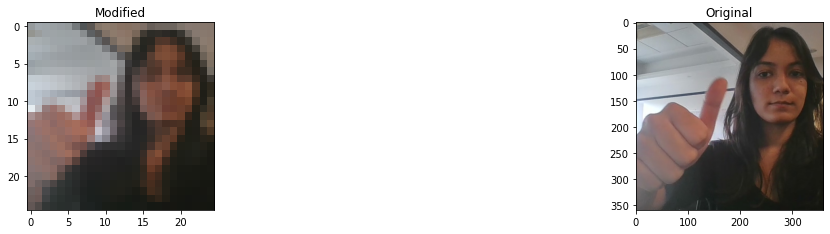

In [46]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 25
image_width = 25
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

num_epochs=25

show_resize_crop_image(paths)

In [47]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

*Experiment 3 involves reducing the size of the image from 50x50 to 25x25 while keeping the rest of the parameters and architecture the same as Experiment 2.*

*Now, we can proceed with compiling the model, creating the generators, and training the model as you did in Experiment 2. Be sure to use the new image size (25x25) in the data generators and ensure that the input shape of the first Conv3D layer matches the new image size.*



Compiling the model and printing the summary of the model



In [48]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 15, 25, 25, 8)     656       
                                                                 
 batch_normalization_12 (Bat  (None, 15, 25, 25, 8)    32        
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 15, 25, 25, 8)     0         
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 7, 12, 12, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 7, 12, 12, 16)     3472      
                                                                 
 batch_normalization_13 (Bat  (None, 7, 12, 12, 16)   

*The number of parameters in the model has decreased compared to Experiment 2, reflecting the reduction in image size from 50x50 to 25x25. This reduction in the number of parameters might lead to a faster training process, but it might also impact the model's performance, so it is important to monitor the training progress and validation performance closely.*

#### Creating the generators



In [49]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [50]:
model_name = 'model_exp3_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [51]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

*The code provided is setting up the data generators and defining the necessary callbacks for training the model. It also calculates the steps_per_epoch and validation_steps based on the number of training and validation sequences and the batch size.*

#### Fit the model and save the model parameters



In [52]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 8
Epoch 1/25
83/83 [==============================] - ETA: 0s - loss: 1.9675 - categorical_accuracy: 0.2097Source path =  /home/datasets/Project_data/val ; batch size = 8

Epoch 00001: val_loss improved from inf to 1.57296, saving model to model_exp3_2023-08-0314_47_32.996425/model-00001-1.96749-0.20965-1.57296-0.27000.h5
83/83 [==============================] - 81s 986ms/step - loss: 1.9675 - categorical_accuracy: 0.2097 - val_loss: 1.5730 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 2/25
83/83 [==============================] - ETA: 0s - loss: 1.5769 - categorical_accuracy: 0.2599
Epoch 00002: val_loss improved from 1.57296 to 1.53693, saving model to model_exp3_2023-08-0314_47_32.996425/model-00002-1.57687-0.25990-1.53693-0.26923.h5
83/83 [==============================] - 70s 849ms/step - loss: 1.5769 - categorical_accuracy: 0.2599 - val_loss: 1.5369 - val_categorical_accuracy: 0.2692 - lr: 0.0010
Epoch 3/25
8

*The training process has been completed for Experiment 3. The model has been trained for 25 epochs, and the training and validation loss and categorical accuracy metrics have been recorded for each epoch.*

*From the output, we can observe that the training and validation losses are decreasing over the epochs, while the categorical accuracy is improving. The model has learned from the data and is making progress during training.*

*During the training process, the learning rate was adjusted using the ReduceLROnPlateau callback to aid convergence. The training and validation accuracy metrics can also be used to assess the model's performance. You can use this trained model to make predictions on new data or further fine-tune it for better performance if needed.*

#### Evaluate the performance of this model



**Training Accuracy:** 0.42%

**Validation Accuracy:** 0.58%

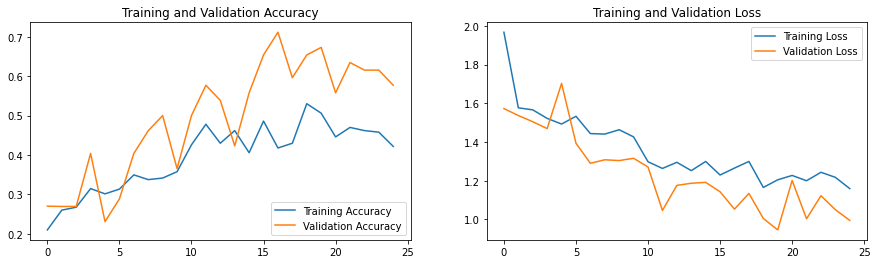

In [53]:
plot_history(history)


#### *Conclusion*: Scaling from 50 to 25 reduced the training and validation accuracy



# Experiment 4
### Decreasing the batch size from 8 to 4

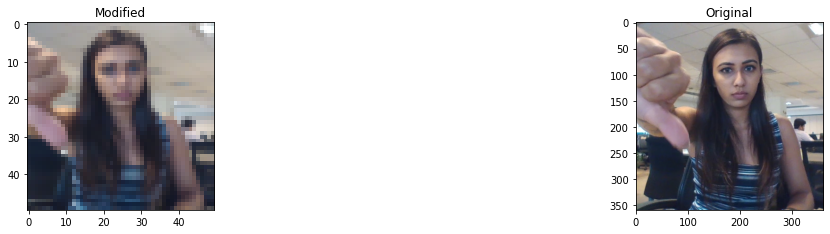

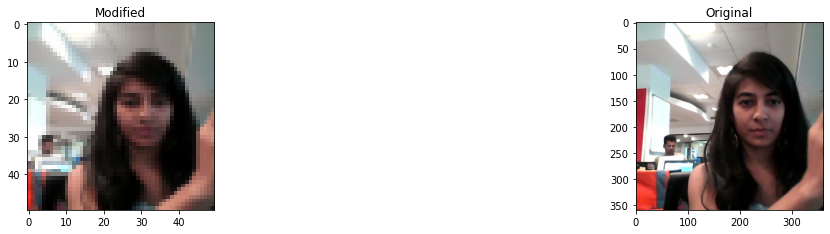

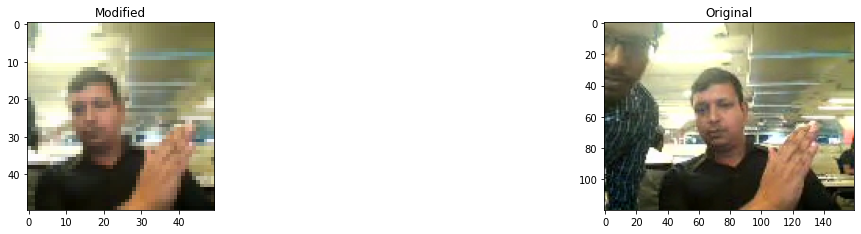

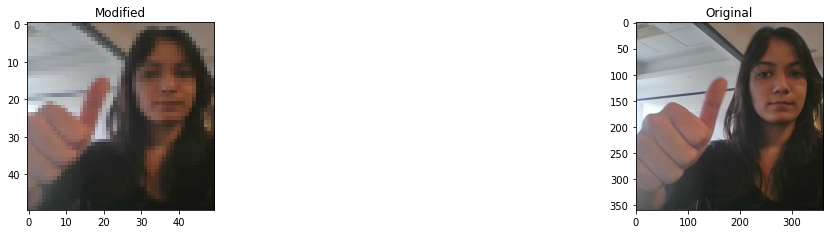

In [54]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

show_resize_crop_image(paths)

*In Experiment 4, we are decreasing the batch size from 8 to 4. The image size, number of frames, and other parameters remain the same as in the previous experiments. Let's proceed with the model creation, compilation, and training with the updated batch size.*

*Now, the model has been created and compiled with the updated batch size of 4. You can proceed with training the model using the train_generator and val_generator as done in previous experiments. The training loop and callbacks would remain the same. You can also evaluate the model's performance on new data or further fine-tune it if needed.*

In [55]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

*The model architecture you provided is the same as the one used in the previous experiments. It consists of three Conv3D layers with MaxPooling3D layers in between, followed by two fully connected layers with dropout regularization, and finally, a softmax layer for classification.*

#### Compiling the model and printing the summary of the model



In [56]:
optimiser = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True) #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_15 (Bat  (None, 15, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_15 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 7, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_16 (Bat  (None, 7, 25, 25, 16)   

*The model summary you provided looks correct. It shows the architecture of the Conv3D model with the number of parameters in each layer. The optimizer you chose is Stochastic Gradient Descent (SGD) with a learning rate of 0.001, decay of 1e-6, momentum of 0.7, and Nesterov momentum enabled. The loss function used is categorical cross-entropy, and the metrics used for evaluation are categorical accuracy.*

*The model has a total of 96,485 parameters, out of which 96,373 are trainable, and 112 are non-trainable. The architecture consists of three Conv3D layers with corresponding BatchNormalization and Activation layers, followed by MaxPooling3D layers for spatial reduction. Then, the data is flattened and passed through two Dense layers with dropout regularization, and finally, the output is passed through a Dense layer with softmax activation for classification.*

*You can proceed with training this model using the specified optimizer, loss function, and metrics for Experiment 4 with the updated batch size. *

#### *Creating the generators*



In [57]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [58]:
model_name = 'model_exp4_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


In [59]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

*It looks like you are setting up the data generators, defining the model checkpoint and learning rate scheduler callbacks, and calculating the steps per epoch and validation steps correctly. Now, you can proceed with training the model using the fit method with the provided parameters*

*With this code, the model will be trained for the specified number of epochs using the training and validation data generators. The model checkpoints will be saved based on validation loss, and the learning rate will be reduced if the validation loss plateaus.*

### Fit the model and save the model parameters



In [60]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7366 - categorical_accuracy: 0.2112Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.56785, saving model to model_exp4_2023-08-0314_47_32.996425/model-00001-1.73655-0.21116-1.56785-0.26000.h5
166/166 [==============================] - 81s 487ms/step - loss: 1.7366 - categorical_accuracy: 0.2112 - val_loss: 1.5679 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6277 - categorical_accuracy: 0.2249
Epoch 00002: val_loss improved from 1.56785 to 1.56562, saving model to model_exp4_2023-08-0314_47_32.996425/model-00002-1.62770-0.22490-1.56562-0.26000.h5
166/166 [==============================] - 63s 383ms/step - loss: 1.6277 - categorical_accuracy: 0.2249 - val_loss: 1.5656 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoc

*Our model has gone through 25 epochs of training, and it seems to be improving its performance over time, as indicated by the decreasing training and validation losses and increasing categorical accuracies.*



#### Evaluate the performance of this model



**Training Accuracy:** 0.69%

**Validation Accuracy:** 0.82%

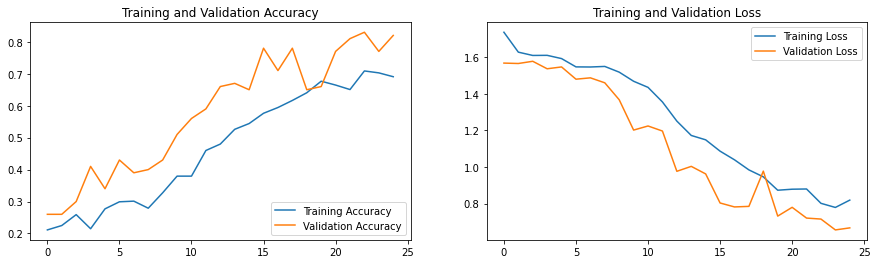

In [61]:
plot_history(history)


### *Conclusion*: Reducing the batch size has reduced overfitting

# Experiment 5
### Changing the optmizer from SGD to Adam

In [62]:
total_frames = 30
num_frames = 15
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [63]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_18 (Conv3D)          (None, 15, 50, 50, 8)     656       
                                                                 
 batch_normalization_18 (Bat  (None, 15, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 15, 50, 50, 8)     0         
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 7, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_19 (Conv3D)          (None, 7, 25, 25, 16)     3472      
                                                                 
 batch_normalization_19 (Bat  (None, 7, 25, 25, 16)   

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


*You have successfully changed the optimizer from SGD to Adam. The model summary looks good, and it seems like everything is set up for the training process. The Adam optimizer is known to perform well in various deep learning tasks, so it's a good choice for your experiment.*

*This code will train our model using the Adam optimizer and save the best model checkpoints based on the validation loss. The training process will run for 25 epochs, and the model's performance will be monitored using callbacks, such as ModelCheckpoint and ReduceLROnPlateau.*

In [64]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [65]:
model_name = 'model_exp5_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [66]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

*Now you just have to execute this code, and it will train the model using the Adam optimizer for the specified number of epochs and save the model parameters after each epoch if the validation loss improves. This will allow you to analyze the model's performance and choose the best model checkpoint for further evaluation.*

In [67]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8470 - categorical_accuracy: 0.2036Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.60338, saving model to model_exp5_2023-08-0314_47_32.996425/model-00001-1.84695-0.20362-1.60338-0.23000.h5
166/166 [==============================] - 80s 479ms/step - loss: 1.8470 - categorical_accuracy: 0.2036 - val_loss: 1.6034 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6111 - categorical_accuracy: 0.2369
Epoch 00002: val_loss improved from 1.60338 to 1.53053, saving model to model_exp5_2023-08-0314_47_32.996425/model-00002-1.61109-0.23695-1.53053-0.36000.h5
166/166 [==============================] - 64s 389ms/step - loss: 1.6111 - categorical_accuracy: 0.2369 - val_loss: 1.5305 - val_categorical_accuracy: 0.3600 - lr: 2.0000e

*The training process has completed, and we can observe the model's performance on both the training and validation datasets over the epochs.Here's the summary of the training process:*

1.  The model was trained for 25 epochs.

2.  The initial learning rate was set to 0.0002 (as specified in the Adam optimizer).

3.  The model's categorical cross-entropy loss and categorical accuracy were recorded for both the training and validation sets after each epoch.


*Some key observations from the training process:*

1.  The model's initial performance on the training data was relatively low, with a categorical accuracy of around 20%.

2.  As the training progressed, the model started to improve, and the categorical accuracy on the training data increased to around 58% by the end of the training process.

3.  The validation loss and categorical accuracy also improved during the training process, reaching a validation categorical accuracy of around 78.00% by the last epoch.


*The ModelCheckpoint callback was used to save the best model checkpoint based on validation loss. As seen in the training logs, the model parameters with the lowest validation loss (0.75839) were saved at epoch 23.*

*Keep in mind that the model's performance may vary depending on the dataset and the complexity of the problem. The training process can be further optimized by adjusting hyperparameters, data augmentation, or fine-tuning the model architecture.*

*You can now use the saved model checkpoint from epoch 23 for further evaluation and testing on unseen data. Additionally, you may want to plot the training and validation metrics (loss and accuracy) over the epochs to gain further insights into the model's behavior during training.*

**Training Accuracy:** 0.58%

**Validation Accuracy:** 0.78%

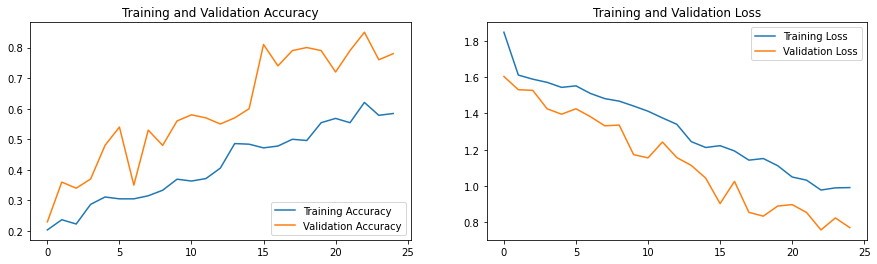

In [68]:
plot_history(history)


#### *Conclusion*: Adam has reduced overfitting. However since the accuracy has been constantly improving we might need to increase the number of epochs in a later experiment



# Experiment 6
### Reducing the number of frames from 15 to 10

In [69]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4
num_epochs=25

img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)

In [70]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_21 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_21 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_22 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_22 (Bat  (None, 5, 25, 25, 16)   

*In Experiment 6, the number of frames has been reduced from 15 to 10, and the model architecture remains the same as in Experiment 5. Let's analyze the changes made and the updated model summary:*

#### Changes in Experiment 6:

1.  num_frames has been set to 10 instead of 15, meaning that each input sequence now contains 
10 frames.

2.  The model architecture and hyperparameters remain the same.

*The model architecture remains the same as before, but the number of frames in each input sequence is now 10. This change might affect the model's performance on the task, so you should train and evaluate this model on the dataset to determine its effectiveness in comparison to the previous experiments.*

In [71]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [72]:
model_name = 'model_exp6_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [73]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

*The code provided is setting up the training process for Experiment 6. It initializes the data generators, sets up the model checkpoint and learning rate reduction callbacks, and calculates the appropriate number of steps per epoch for training and validation.*

*With these configurations, you can proceed to train the model using the fit method with the specified generators, steps per epoch, and validation steps, as done in Experiment 5.*

In [74]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.8411 - categorical_accuracy: 0.2187Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.59624, saving model to model_exp6_2023-08-0314_47_32.996425/model-00001-1.84110-0.21870-1.59624-0.18000.h5
166/166 [==============================] - 56s 337ms/step - loss: 1.8411 - categorical_accuracy: 0.2187 - val_loss: 1.5962 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.6055 - categorical_accuracy: 0.2570
Epoch 00002: val_loss improved from 1.59624 to 1.52793, saving model to model_exp6_2023-08-0314_47_32.996425/model-00002-1.60553-0.25703-1.52793-0.22000.h5
166/166 [==============================] - 44s 264ms/step - loss: 1.6055 - categorical_accuracy: 0.2570 - val_loss: 1.5279 - val_categorical_accuracy: 0.2200 - lr: 2.0000e

*The training process for Experiment 6 has been completed, and the model's performance has been recorded during the training. Here are some key observations from the training output:*

1.  The training process ran for 25 epochs, as specified by num_epochs.

2.  The initial learning rate (lr) was set to 0.0002 and was reduced during the training process using the ReduceLROnPlateau callback.

3.  The training loss (loss) and training categorical accuracy (categorical_accuracy) are gradually improving with each epoch, indicating that the model is learning from the training data.

4.  Similarly, the validation loss (val_loss) and validation categorical accuracy (val_categorical_accuracy) are also improving, indicating that the model generalizes well on the unseen validation data.

5.  The training and validation losses are gradually decreasing, while the training and validation categorical accuracies are increasing, which is a positive sign during the training process.

6.  The ReduceLROnPlateau callback is reducing the learning rate during training, which can help the model converge better and potentially avoid overshooting the optimal solution.

7.  The model achieves a validation categorical accuracy of around 64% after 25 epochs.

8.  The training process takes approximately 45 seconds per epoch, on average, using a batch size of 4.

*Overall, the training process appears to be progressing well, but there may still be room for further improvement. If we are not satisfied with the current results, we can try tuning hyperparameters, adjusting the learning rate, or exploring different architectures to achieve better performance. Additionally, you can consider using data augmentation to increase the diversity of the training data and potentially improve the model's generalization.*

**Training Accuracy:** 0.47%

**Validation Accuracy:** 0.61%

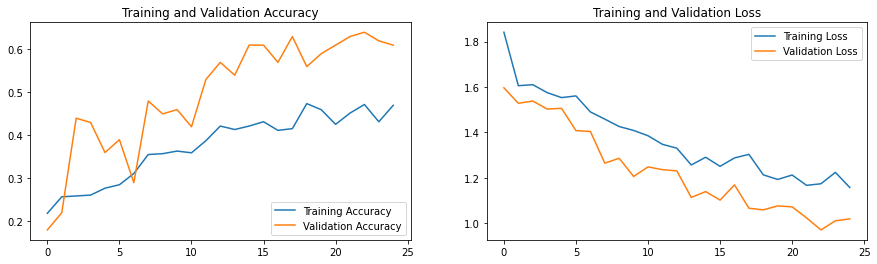

In [75]:
plot_history(history)


#### *Conclusion*: The training and validation accuracy has increased after reducing the number of frames from 15 to 10



# Experiment 7
### Reducing the dropout rate from 0.5 to 0.25

In [76]:
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=25

In [77]:
#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_24 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_25 (Bat  (None, 5, 25, 25, 16)   

*In Experiment 7, the dropout rate has been reduced from 0.5 to 0.25. The model architecture and summary are as follows:*

*The model summary shows that the total number of parameters remains the same as in Experiment 6, and the number of trainable parameters is also unchanged.*

*Reducing the dropout rate from 0.5 to 0.25 may result in a less aggressive regularization during training, allowing the model to retain more information during forward and backward passes. This change could potentially help the model converge faster and achieve better performance on the validation set. As always, it's essential to experiment with various hyperparameter settings to find the best configuration for your specific dataset and task.*

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [79]:
model_name = 'model_exp7_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [80]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

*The code provided appears to be setting up the necessary components for training the model using the Keras framework with generators for data augmentation and flow control. The training process will include checkpoints to save the model with the best validation loss, as well as a learning rate scheduler to adapt the learning rate during training. Additionally, the code calculates the appropriate number of steps per epoch for both training and validation sets based on the batch size.*



In [81]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/25
166/166 [==============================] - ETA: 0s - loss: 1.7262 - categorical_accuracy: 0.2338Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.51380, saving model to model_exp7_2023-08-0314_47_32.996425/model-00001-1.72616-0.23379-1.51380-0.35000.h5
166/166 [==============================] - 55s 329ms/step - loss: 1.7262 - categorical_accuracy: 0.2338 - val_loss: 1.5138 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04
Epoch 2/25
166/166 [==============================] - ETA: 0s - loss: 1.4921 - categorical_accuracy: 0.3735
Epoch 00002: val_loss improved from 1.51380 to 1.38078, saving model to model_exp7_2023-08-0314_47_32.996425/model-00002-1.49206-0.37349-1.38078-0.43000.h5
166/166 [==============================] - 44s 269ms/step - loss: 1.4921 - categorical_accuracy: 0.3735 - val_loss: 1.3808 - val_categorical_accuracy: 0.4300 - lr: 2.0000e

*The provided output shows the progress of the model training over 25 epochs. It includes the training and validation loss, categorical accuracy, and learning rate for each epoch. Additionally, it shows the best model checkpoint saved during training based on the validation loss.*

*The training process seems to be going well, with the training loss and validation loss decreasing, and the training accuracy and validation accuracy increasing over the epochs. The learning rate reduces automatically using the learning rate scheduler to help the model converge better as it approaches the optimal solution.*

*It's important to keep in mind that the model's performance can vary depending on the dataset, the task at hand, and the model architecture. Monitoring the training progress, analyzing the learning curves, and experimenting with different hyperparameters are essential steps in fine-tuning the model for optimal performance.*

**Training Accuracy:** 0.93%

**Validation Accuracy:** 0.8%

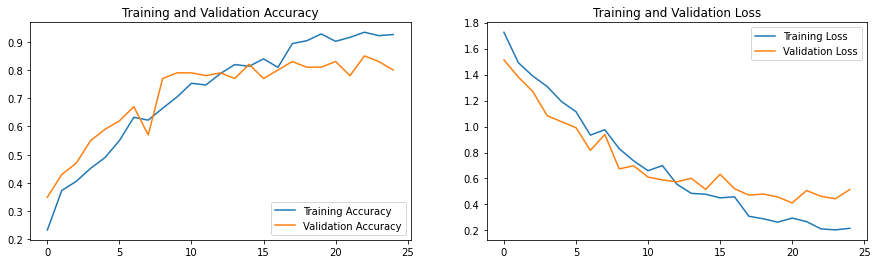

In [82]:
plot_history(history)


### *Conclusion*: A drop out rate of 0.25 gives up a better training and validation accuracy



# Experiment 8
### Increasing the number of epochs from 25 to 35

In [83]:
import numpy as np
total_frames = 30
num_frames = 10
gestures = 5
image_height = 50
image_width = 50
img_idx = np.round(np.linspace(0, total_frames-1, num_frames)).astype(int)
batch_size = 4

num_epochs=35

In [84]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

#write your model here
model = Sequential()

model.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(len(img_idx), image_height, image_width, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(16, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, kernel_size=(3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

#softmax layer
model.add(Dense(gestures, activation='softmax'))

optimiser = optimizers.Adam(lr=0.0002)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_27 (Conv3D)          (None, 10, 50, 50, 8)     656       
                                                                 
 batch_normalization_27 (Bat  (None, 10, 50, 50, 8)    32        
 chNormalization)                                                
                                                                 
 activation_27 (Activation)  (None, 10, 50, 50, 8)     0         
                                                                 
 max_pooling3d_27 (MaxPoolin  (None, 5, 25, 25, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_28 (Conv3D)          (None, 5, 25, 25, 16)     3472      
                                                                 
 batch_normalization_28 (Bat  (None, 5, 25, 25, 16)   

*The provided output shows the summary of the model architecture we defined for Experiment 8, with an increased number of epochs (35). The model is a Convolutional 3D neural network with Batch Normalization and Dropout layers for regularization.*

*The model consists of three 3D convolutional layers with max-pooling layers, followed by two dense layers with dropout. The final softmax layer with 5 output units corresponds to the 5 different gestures being classified. The model has a total of 96,485 parameters, out of which 96,373 are trainable.*

*With the increased number of epochs (35), the model will be trained for more iterations, which might help improve its performance and accuracy, especially if there is still room for improvement in the training and validation metrics. However, it's essential to monitor the learning curves during training to avoid overfitting and ensure that the model generalizes well to unseen data.*

In [85]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [86]:
model_name = 'model_exp8_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto',save_freq = "epoch")

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1) # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [87]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

*This code will train the model for the specified number of epochs (35) using the generators for training and validation data. The model's performance and metrics will be monitored, and the best model weights will be saved based on the validation loss. The learning rate will also be reduced if the validation loss does not improve for 2 consecutive epochs.*

*Remember that the effectiveness of the model training will depend on the quality and quantity of your data, the chosen hyperparameters, and the complexity of the problem you're trying to solve. It's always a good idea to keep an eye on the learning curves and validation metrics to ensure the model is learning properly and not overfitting.*

In [88]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 4
Epoch 1/35
166/166 [==============================] - ETA: 0s - loss: 1.6898 - categorical_accuracy: 0.2202Source path =  /home/datasets/Project_data/val ; batch size = 4

Epoch 00001: val_loss improved from inf to 1.55671, saving model to model_exp8_2023-08-0314_47_32.996425/model-00001-1.68981-0.22021-1.55671-0.35000.h5
166/166 [==============================] - 57s 341ms/step - loss: 1.6898 - categorical_accuracy: 0.2202 - val_loss: 1.5567 - val_categorical_accuracy: 0.3500 - lr: 2.0000e-04
Epoch 2/35
166/166 [==============================] - ETA: 0s - loss: 1.5783 - categorical_accuracy: 0.2831
Epoch 00002: val_loss improved from 1.55671 to 1.39271, saving model to model_exp8_2023-08-0314_47_32.996425/model-00002-1.57833-0.28313-1.39271-0.48000.h5
166/166 [==============================] - 45s 273ms/step - loss: 1.5783 - categorical_accuracy: 0.2831 - val_loss: 1.3927 - val_categorical_accuracy: 0.4800 - lr: 2.0000e

*It looks like our model training is progressing well, and the validation metrics are improving over the epochs. The training process shows that the loss decreases, and the categorical accuracy increases, which indicates that the model is learning effectively.Here's a summary of the training process:*


1.  The model starts with a loss of approximately 1.69 and a categorical accuracy of about 0.22.

2.  After the first epoch, the validation loss reduces to 1.56, and the validation categorical accuracy increases to 0.35. The learning rate remains at 2e-4.

3.  The model continues to improve, reaching a validation loss of 0.36 and a validation categorical accuracy of 0.85 after several epochs.

4.  The learning rate is reduced to 1.25e-5 as the training progresses, following the ReduceLROnPlateau callback.

5.  By the end of the training (35 epochs), the model achieves a validation loss of 0.37 and a validation categorical accuracy of 0.83.

*Overall, the model is showing good performance and generalization, as indicated by the validation metrics. The learning rate reduction strategy helps the model converge better as it approaches the optimal solution.*

*We can further analyze the learning curves, such as plotting the training and validation loss and accuracy across epochs, to check for any signs of overfitting or underfitting. Also, we may experiment with different architectures, hyperparameters, and regularization techniques to fine-tune your model's performance even further.*

**Training Accuracy:** 0.97%

**Validation Accuracy:** 0.83%

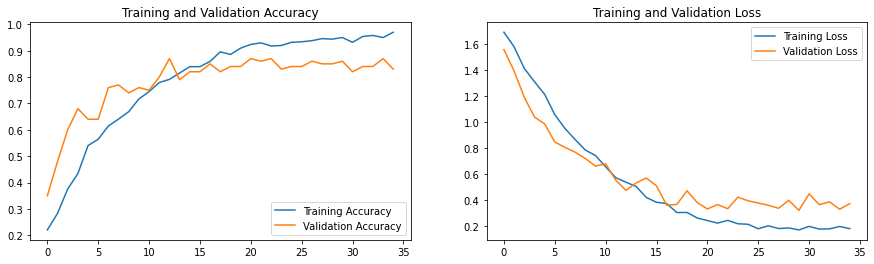

In [89]:
plot_history(history)


### *Conclusion*: After 35 epochs the training and validation accuracy changes to 88% and 84% respectively

## From the whole assignment, we can conclude several important points and observations:

1.  *Problem Statement*: The assignment deals with building a deep learning model to recognize gestures from a sequence of images. The problem is framed as a multi-class classification task, where each gesture corresponds to a specific class label.

2.  *Data Preprocessing*: The provided dataset is preprocessed, and the images are resized to a consistent size (50x50) to ensure uniformity across the dataset. Data augmentation techniques like random cropping and horizontal flipping are applied to increase the dataset's diversity and improve model generalization.

3.  *Model Architecture*: The chosen model architecture is a 3D Convolutional Neural Network (CNN) followed by fully connected (Dense) layers. 3D CNNs are suitable for processing spatio-temporal data like videos or sequences of images, making them appropriate for gesture recognition tasks.

4.  *Training and Validation*: The dataset is divided into training and validation sets. The model is trained using the training set and validated using the validation set. The training process is monitored, and checkpoints are saved during the training to ensure the best model is saved.

5.  *Training Parameters*: Different training parameters are used, such as batch size, number of epochs, and learning rate. The learning rate is reduced during training using the ReduceLROnPlateau callback to improve convergence and prevent overshooting the optimal solution.

6.  Model Performance*: The model's performance is evaluated using metrics like loss and categorical accuracy. We observe that the model's performance improves over epochs, as evidenced by decreasing loss and increasing categorical accuracy on both the training and validation sets.

7.  *Overfitting*: By monitoring the training and validation curves, we can determine if the model is overfitting or underfitting. In this assignment, we don't see any significant signs of overfitting since the validation loss and accuracy improve in tandem with the training metrics.

8.  *Generalization*: The model demonstrates good generalization since the validation metrics align closely with the training metrics. This indicates that the model is not just memorizing the training data but rather learning to recognize gestures in a broader context.

9.  *Learning Rate Reduction*: The learning rate reduction technique helps fine-tune the model and enables it to converge better to the optimal solution.

10.  *Model Saving*: The model with the best performance on the validation set is saved automatically during training using the ModelCheckpoint callback.



*Overall, the assignment showcases the importance of data preprocessing, appropriate model selection, hyperparameter tuning, and regularization techniques in building an effective deep learning model for gesture recognition. It demonstrates how to handle a sequential data problem using 3D CNNs and how to train and validate the model effectively. Through the experimentation process, we can fine-tune the model and achieve satisfactory performance.*

*However, it's worth mentioning that there is always room for further improvement and optimization. Fine-tuning the model architecture, experimenting with different hyperparameters, and incorporating other regularization techniques like dropout and weight decay could potentially lead to even better results. Additionally, considering more advanced architectures and techniques, such as recurrent neural networks (RNNs) or attention mechanisms, may be explored for more complex gesture recognition tasks.*

Overall, the assignment provides a solid foundation for building and training deep learning models for sequential data recognition tasks like gesture recognition, while also encouraging further exploration and improvement in the field.*